# Imports

In [ ]:
from __future__ import division  # always use float division
import numpy as np
from scipy.spatial.distance import cdist  # fast distance matrices
from scipy.cluster.hierarchy import dendrogram  # you can use this
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D  # for when you create your own dendrogram

# Function Definitions - Implementation

In [ ]:
def kmeans(X, k, max_iter=100, output=True):
    muselect = 0
    mu = np.random.rand(k, len(X[0]))
    mins = np.min(X, axis=0)
    maxs = np.max(X, axis=0)
    if muselect == 1:
        mu = np.random.rand(k, len(X[0]))
        mu += mins
        mu *= maxs
    elif muselect == 0:
        X_shuffle = np.array(X)
        np.random.shuffle(X_shuffle)
        mu = X_shuffle[0:k]
    r = np.empty(len(X))
    r_new = np.ones(len(X))
    iteration = 0
    error=0.
    while not np.array_equal(r,r_new) and iteration < max_iter:
        error=0.
        iteration+=1
        if output:
            print('Peforming iteration ' + str(iteration) + ':')
        r = r_new
        dis = (-2 * X @ mu.T + (np.sum(X ** 2, axis=1) + np.sum(mu ** 2, axis=1)[:, np.newaxis]).T)**0.5
        r_new = np.argmin(dis, axis=1)
        if output:
            print('Changed cluster memberships: ' +  str(np.count_nonzero(r_new-r)) + ' datapoints')
        for i in range(0, k):
            if(len(np.where(r_new==i)[0])>0):
                mu[i] = np.sum(X[np.where(r_new==i)], axis=0)/len(np.where(r_new==i)[0])
                error += np.sum(dis[np.where(r_new==i),i])
            else:
                mu[i] = (np.random.rand(len(mins)) * maxs + mins)
        if output:
            print('Loss: ' + str(error))
    return mu, r_new, error

In [ ]:
def agglo(X_a, r_a):
    #reconstruct original data
    k_org = max(r_a)+1
    org_err = 0.
    kmus = np.zeros((k_org,len(X_a[0])))
    #calculate cluster centers
    for i in np.unique(r_a):
        if(len(np.where(r_a==i)[0])>0):
            kmus[i] = np.sum(X_a[np.where(r_a==i)], axis=0)/len(np.where(r_a==i)[0])
            #org_err += np.sum(org_dis[np.where(r_a==i),i])
            #calculate distances
    org_dis = (-2 * X_a @ kmus.T + (np.sum(X_a ** 2, axis=1) + np.sum(kmus ** 2, axis=1)[:, np.newaxis]).T)**0.5
    #calculate errors
    for i in np.unique(r_a):
        if(len(np.where(r_a==i)[0])>0):
            org_err += np.sum(org_dis[np.where(r_a==i),i])
    #create return variable    
    R = np.array([r_a])
    kmloss = np.array([org_err])
    mergeidx = np.array([])
    costs = np.zeros((k_org,k_org))
    #for each combination of clusters (one way, not both ways) calculate cost of merging
    for first in range(0, k_org-1):
        if len(np.where(r_a==first)[0])>0:
            for second in range(first+1, k_org):
                if len(np.where(r_a==second)[0])>0:
                    if first != second:
                        numfirst = len(np.where(r_a==first)[0])
                        numsecond = len(np.where(r_a==second)[0])
                        #calculating weighted new clustercenter
                        newmu = (kmus[first]*numfirst+kmus[second]*numsecond)/(numfirst+numsecond)
                        newmus = np.append(kmus, [newmu], axis=0)
                        new_r = np.array(r_a)
                        new_r[np.where(r_a==first)] = k_org
                        new_r[np.where(r_a==second)] = k_org
                        dis = (-2 * X_a @ newmus.T + (np.sum(X_a ** 2, axis=1) + np.sum(newmus ** 2, axis=1)[:, np.newaxis]).T)**0.5
                        costs[first, second] = np.sum(dis[np.arange(dis.shape[0])][new_r])
    #Choose cheapest merge
    lowest_cost = np.min(costs[np.nonzero(costs)])
    indx = np.asarray(np.where(costs == lowest_cost)).flatten()
    merge_r = np.array(r_a)
    merge_r[np.where(merge_r==indx[0])] = k_org
    merge_r[np.where(merge_r==indx[1])] = k_org
    #preparing output
    mergeidx = np.array([indx])
    kmloss = np.append(kmloss, lowest_cost)
    #Recursion if needed:
    if len(np.unique(merge_r))>1:
        #R = np.append(R, [merge_r], axis=0)
        R_n, loss_n, mergeidx_n = agglo(X_a, merge_r)
        mergeidx = np.append(mergeidx, mergeidx_n, axis=0)
        kmloss = np.append(kmloss, loss_n[1:])
        R = np.append(R, [merge_r], axis=0)
    return(R, kmloss, mergeidx)

In [ ]:
def agglo_dendro(kmloss, mergeidx, num=-1):
    """ Plots dendrogram for agglomerative clustering

    Input:
    kmloss: vector with loss after each step
    mergeidx: (k-1) x 2 matrix that contains merge idx for each step
    """
    mergeloss = [[i] for i in kmloss[1:]]
    mergeloss -= kmloss[0]
    placeholder_counts = [[1] for i in kmloss[1:]]
    Z = np.append(mergeidx, mergeloss, axis=1)
    Z = np.append(Z, placeholder_counts, axis=1)
    fig, axis = plt.subplots(nrows=1, ncols=1, figsize=(20, 12))
    dn = dendrogram(Z, ax=axis)
    axis.set_ylabel('Increase in cost', fontsize=20)
    if num>0:
         axis.set_xlabel('Cluster number, initial clusters: ' + str(num), fontsize=20)
    else:
        axis.set_xlabel('Cluster number', fontsize=20)
    pass

In [ ]:
def get_optimal_kmeans(X, k, reps=10):
    toterr = np.array([])
    locop_mu = np.array([])
    globop_mu = np.array([])
    lowmu, lowr, lowerr = kmeans(X, k, output=False)
    for i in range(0,reps-1):
        mu, r, err = kmeans(X, k, output=False)
        toterr = np.append(toterr, err)
        if err<=np.min(toterr):
            lowmu, lowr, lowerr = mu, r, err
    return lowmu, lowr, lowerr

## Testing Area

In [ ]:
X = np.array([[0., 1., 1., 10., 10.25, 11., 10., 10.25, 11.],
                  [0., 0., 1.,  0.,   0.5,  0.,  5.,   5.5,  5.]]).T
k = 3

In [ ]:
X.shape

# Analysis/Application Part

In [62]:
gauss5 = np.load('data/5_gaussians.npy')
gauss5 = gauss5.T
gauss2 = np.load('data/2_gaussians.npy')
gauss2 = gauss2.T

## Ex.7

In [ ]:
g52mu, g52r, g52err = kmeans(gauss5, 2)
g53mu, g53r, g53err = kmeans(gauss5, 3)
g54mu, g54r, g54err = kmeans(gauss5, 4)
g55mu, g55r, g55err = kmeans(gauss5, 5)
g56mu, g56r, g56err = kmeans(gauss5, 6)
g57mu, g57r, g57err = kmeans(gauss5, 7)
fig, axis = plt.subplots(nrows=1, ncols=1, figsize=(20, 12))
axis.scatter(gauss5.T[0], gauss5.T[1])
#axis.scatter(g52mu.T[0], g52mu.T[1])
#axis.scatter(g53mu.T[0], g53mu.T[1])
#axis.scatter(g54mu.T[0], g54mu.T[1])
axis.scatter(g55mu.T[0], g55mu.T[1])
#axis.scatter(g56mu.T[0], g56mu.T[1])
#axis.scatter(g57mu.T[0], g57mu.T[1])

/home/oliver/.local/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in sqrt


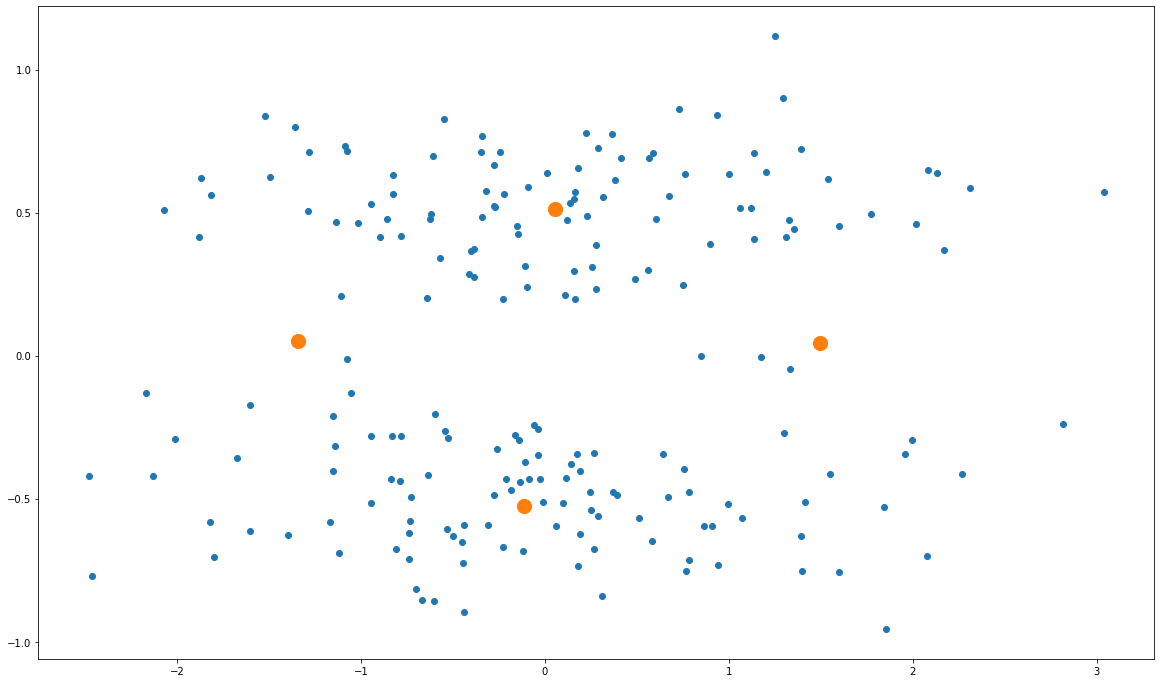

In [77]:
g22mu, g22r, g22err = get_optimal_kmeans(gauss2, 2, False)
g23mu, g23r, g23err = get_optimal_kmeans(gauss2, 3, False)
g24mu, g24r, g24err = get_optimal_kmeans(gauss2, 4, False)
g25mu, g25r, g25err = get_optimal_kmeans(gauss2, 5, False)
g26mu, g26r, g26err = get_optimal_kmeans(gauss2, 6, False)
g27mu, g27r, g27err = get_optimal_kmeans(gauss2, 7, False)
fig, axis = plt.subplots(nrows=1, ncols=1, figsize=(20, 12))
axis.scatter(gauss2.T[0], gauss2.T[1])
#axis.scatter(g22mu.T[0], g22mu.T[1], s=200)
#axis.scatter(g23mu.T[0], g23mu.T[1], s=200)
axis.scatter(g24mu.T[0], g24mu.T[1], s=200)
#axis.scatter(g25mu.T[0], g25mu.T[1], s=200)
#axis.scatter(g26mu.T[0], g26mu.T[1], s=200)
#axis.scatter(g27mu.T[0], g27mu.T[1], s=200)


# Ex.8

## k-means

In [85]:
appl_localOptima(gauss2)

##############################
2 CLUSTERS: 


/home/oliver/.local/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in sqrt


   Global optimun: 156.35, achieved for 3.0% of the samples
   Mean error from 1000 samples: 0.21, which is 0.14% of the optimum
   INCLUDING global optima, 100.0% of the samples are within 2.0% of the global optimum
##############################
3 CLUSTERS: 
   Global optimun: 129.23, achieved for 12.6% of the samples
   Mean error from 1000 samples: 3.4, which is 2.63% of the optimum
   INCLUDING global optima, 29.4% of the samples are within 2.0% of the global optimum
##############################
4 CLUSTERS: 
   Global optimun: 107.19, achieved for 0.1% of the samples
   Mean error from 1000 samples: 2.7, which is 2.52% of the optimum
   INCLUDING global optima, 75.4% of the samples are within 2.0% of the global optimum
##############################
5 CLUSTERS: 
   Global optimun: 94.28, achieved for 0.4% of the samples
   Mean error from 1000 samples: 2.56, which is 2.71% of the optimum
   INCLUDING global optima, 47.3% of the samples are within 2.0% of the global optimum
#####

/home/oliver/.local/lib/python3.6/site-packages/ipykernel_launcher.py:24: RuntimeWarning: invalid value encountered in sqrt


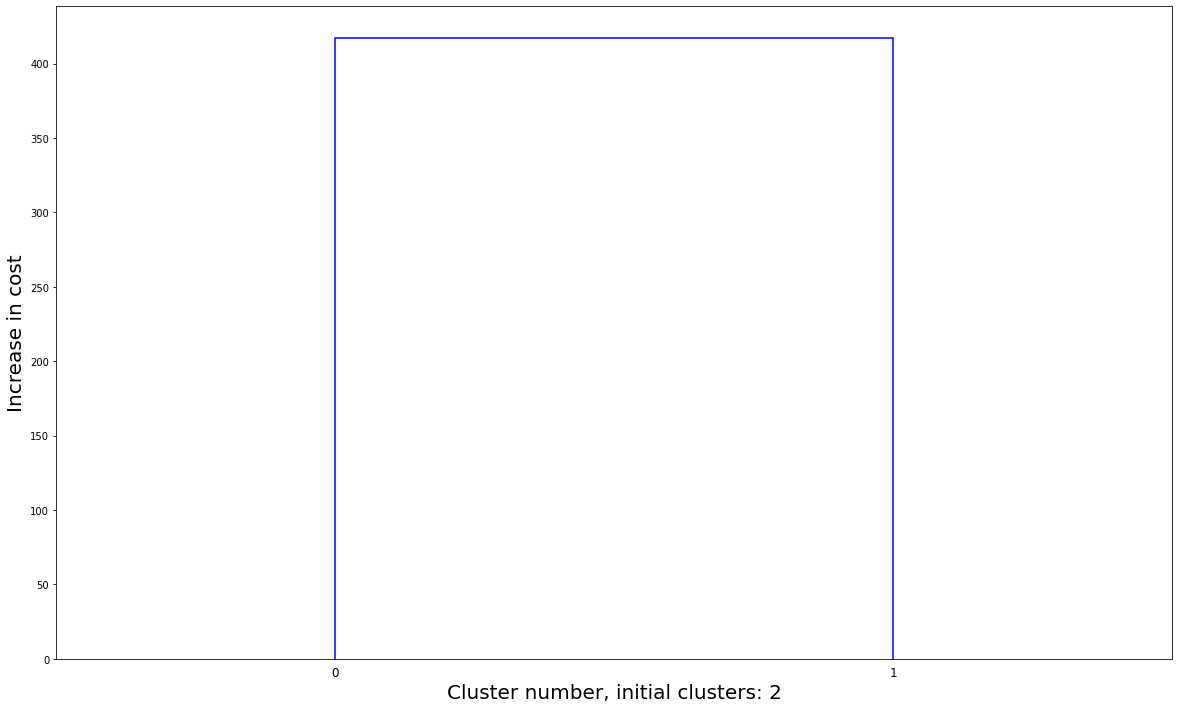

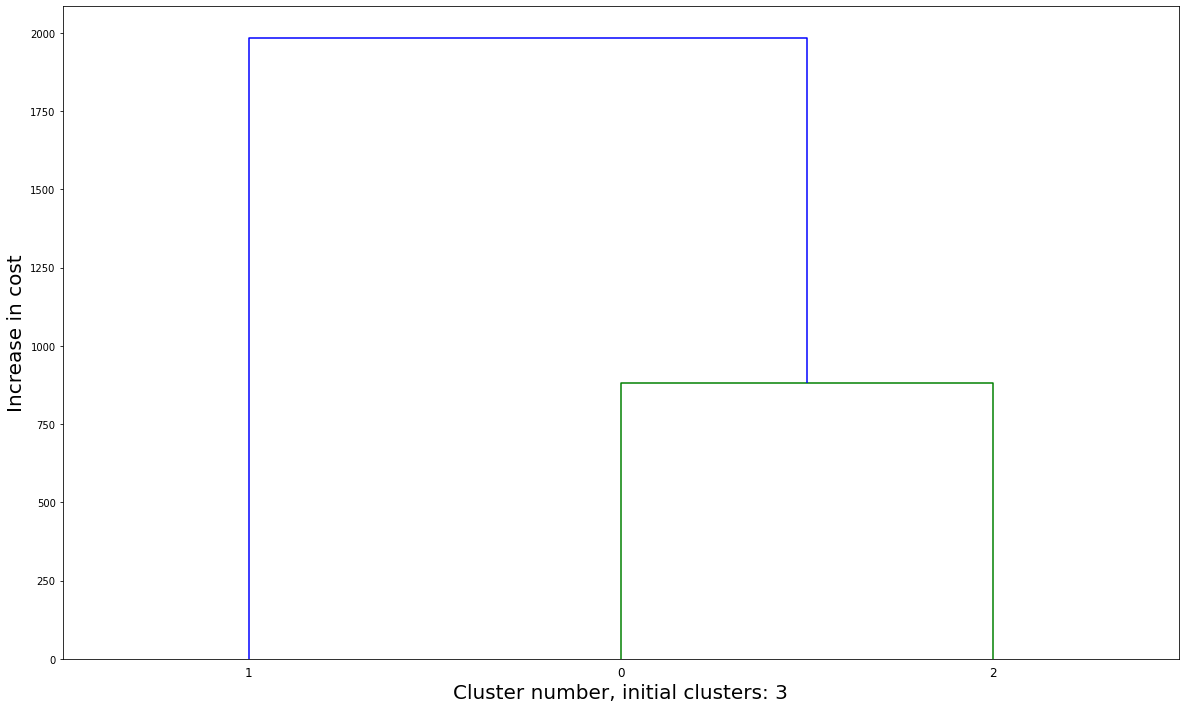

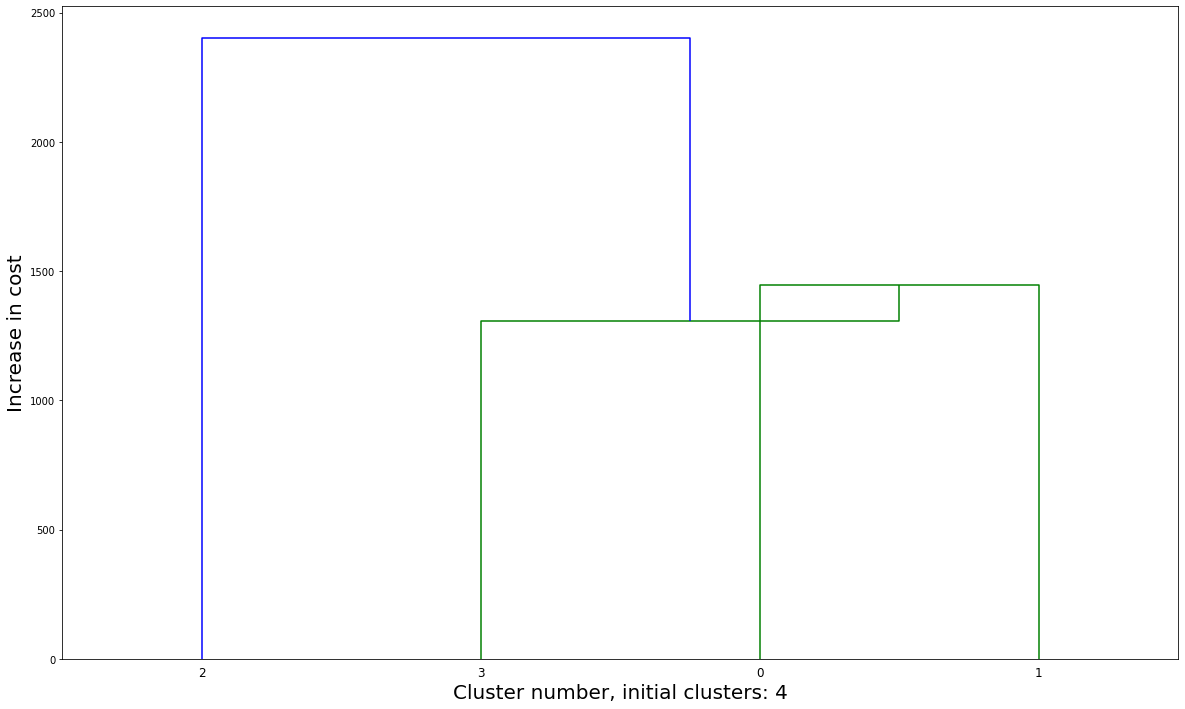

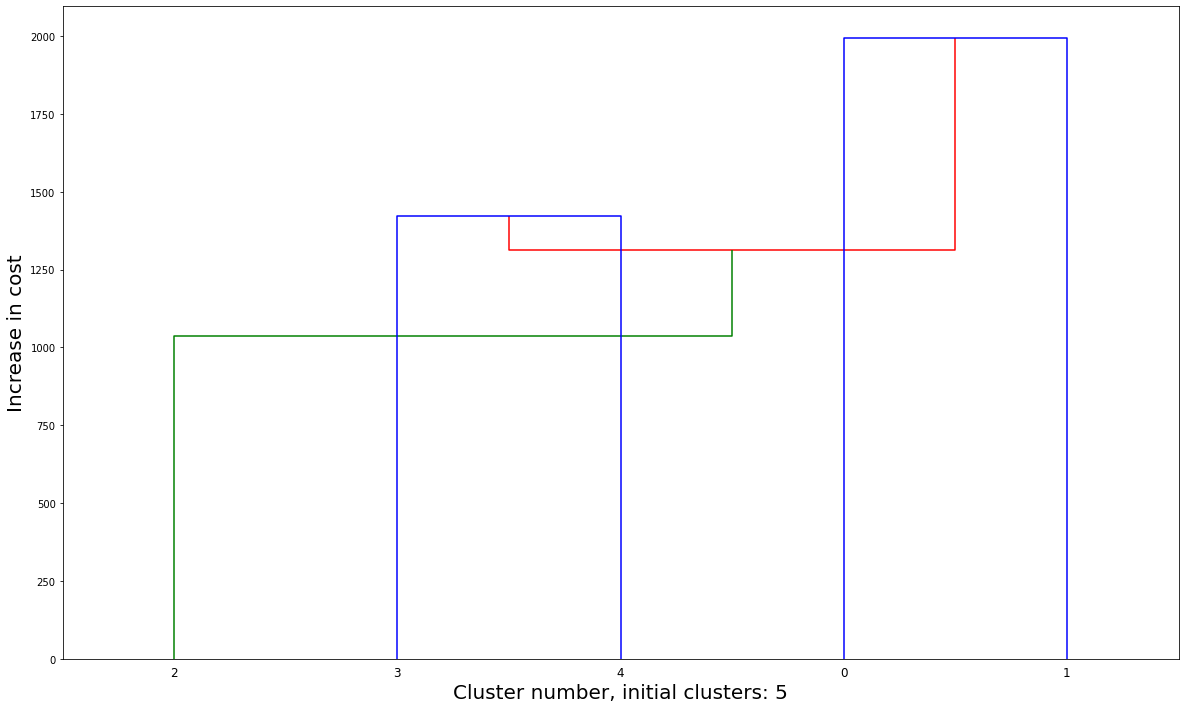

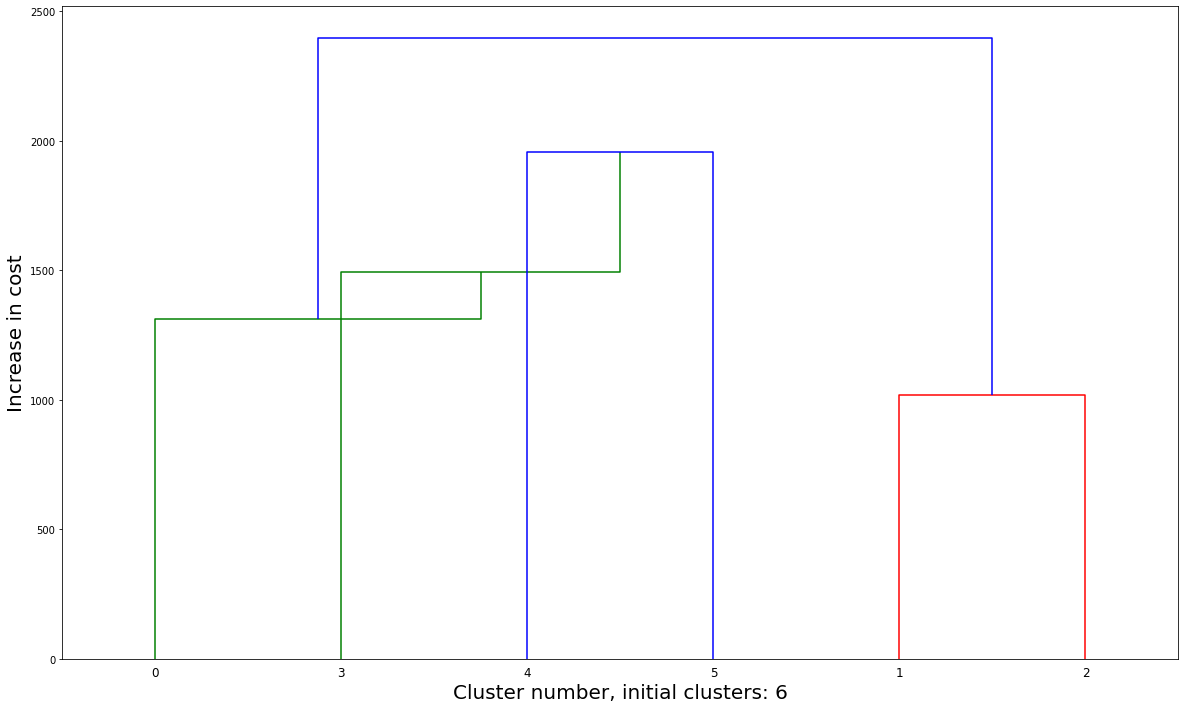

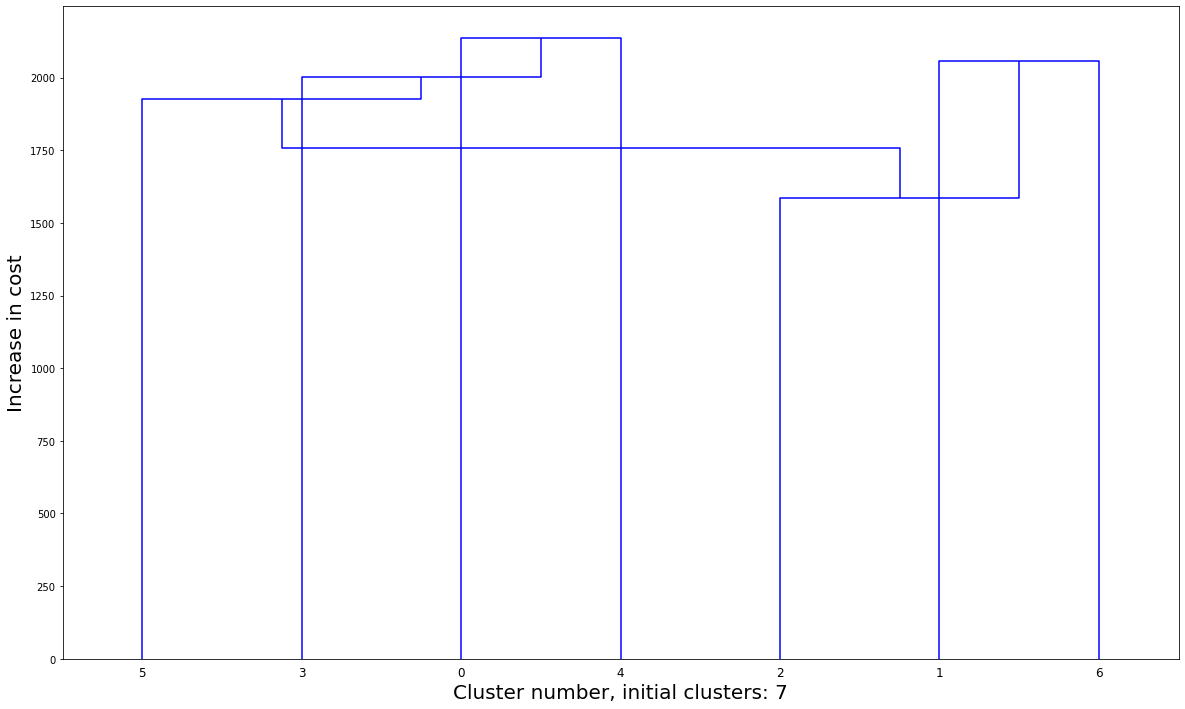

In [86]:
appl_dendo(gauss2)

## Local Optima Check

In [84]:
def appl_localOptima(X, accept_perc=.02, reps=1000, k=7, mode='k'):
    if mode=='k':
        #Globops: 
        #2-460, one locop, rare; 0.54% locop; 41.2 within 2%
        #3-260 (few times one locop); 99.3% globop; 99.7% within 2%
        #4-190, 2 locop, often; 8.3% globop; 49% within 2%
        #5-155, many locop often; 33.9% globop; 33.9% within 2%
        #6-141, many locop, also close to globop, often; 0.12% globop; 27.7% within 2%
        #7-138, many regular locop, also close to globop; 0.08% globop; 21.6% within 2%
        for j in range(2, 8):
            toterr = np.array([])
            locop_mu = np.array([])
            globop_mu = np.array([])
            print("##############################")
            print(str(j) + " CLUSTERS: ")
            for i in range(0,reps):
                mu, r, err = kmeans(X, j, output=False)
                toterr = np.append(toterr, err)
                #print(np.max(toterr))
                if err>=np.max(toterr):
                    locop_mu = mu
                    #print("new max")
                    #print(i)
                    #print(err)
                if err<=np.min(toterr):
                    globop_mu = mu
                    #print("new min")
                    #print(i)
                    #print(err)

            global_optimum = np.min(np.unique(toterr, return_counts=True)[0])
            indx = np.where(np.unique(toterr, return_counts=True)[0]==global_optimum)
            indx = np.asarray(indx)[0,0]
            times = np.unique(toterr, return_counts=True)[1][indx]
            print("   Global optimun: " +str(round(global_optimum,2)) + ", achieved for " + str(round((times/reps)*100,2)) + "% of the samples")
            meanerr = np.sum((toterr - global_optimum)) / (reps-times)
            print("   Mean error from " + str(reps) + " samples: " + str(round(meanerr,2)) + ", which is " + str(round((meanerr/global_optimum)*100,2)) + "% of the optimum")
            perc5 = global_optimum * accept_perc
            inperc = toterr-(perc5+global_optimum)
            inperccount = len(np.where(inperc<0)[0])
            print("   INCLUDING global optima, " + str((inperccount/reps)*100) + "% of the samples are within " + str(accept_perc*100) + "% of the global optimum")
            #fig, axis = plt.subplots(nrows=2, ncols=1, figsize=(12, 16))
            #axis[0].plot(toterr)
            #axis[1].scatter(gauss5.T[0], gauss5.T[1])
            #axis[1].scatter(locop_mu.T[0], locop_mu.T[1])
            #axis[1].scatter(globop_mu.T[0], globop_mu.T[1], c='r')

# Dendogram

It is visible that for merging of cases with more initial clusters than the original data suggests, at some point negative merging costs occur?

In [ ]:
def appl_dendo(X):
    for j in range(2, 8):
        mu, r, err = get_optimal_kmeans(X, j, 100)
        R, kmloss, mergeidx = agglo(X, r)
        agglo_dendro(kmloss, mergeidx, j)

# Notes

In [ ]:
def aggloOld(X_a, r_a):
    #construct original data
    k_org = max(r)+1
    org_err = 0.
    kmus = np.zeros((k_org,len(X[0])))
    org_dis = (-2 * X @ kmus.T + (np.sum(X ** 2, axis=1) + np.sum(kmus ** 2, axis=1)[:, np.newaxis]).T)**0.5
    for i in range(0, k_org):
        if(len(np.where(r==i)[0])>0):
            kmus[i] = np.sum(X[np.where(r==i)], axis=0)/len(np.where(r==i)[0])
            org_err += np.sum(org_dis[np.where(r==i),i])
    #create return variable
    R = np.array([r])
    kmloss = np.array([org_err])
    mergeidx = np.array([])
    costs = np.zeros((k_org,k_org))
    #for each combination of clusters (one way, not both ways) calculate cost of merging
    for first in range(0, k_org-1):
        if len(np.where(r==first)[0])>0:
            for second in range(first+1, k_org):
                if len(np.where(r==second)[0])>0:
                    if first != second:
                        numfirst = len(np.where(r==first)[0])
                        numsecond = len(np.where(r==second)[0])
                        #calculating weighted new clustercenter
                        newmu = (kmus[first]*numfirst+kmus[second]*numsecond)/(numfirst+numsecond)
                        newmus = np.append(kmus, [newmu], axis=0)
                        new_r = np.array(r)
                        new_r[np.where(r==first)] = k_org
                        new_r[np.where(r==second)] = k_org
                        dis = (-2 * X @ newmus.T + (np.sum(X ** 2, axis=1) + np.sum(newmus ** 2, axis=1)[:, np.newaxis]).T)**0.5
                        costs[first, second] = np.sum(dis[np.arange(dis.shape[0]),new_r])
    #Choose cheapest merge
    lowest_cost = np.min(costs[np.nonzero(costs)])
    indx = np.asarray(np.where(costs == lowest_cost)).flatten()
    merge_r = np.array(r)
    merge_r[np.where(merge_r==indx[0])] = k_org
    merge_r[np.where(merge_r==indx[1])] = k_org
    #preparing output
    if(len(R)==1): #needed for first entry
        mergeidx = np.array([indx])
    else:
        mergeidx = np.append(mergeidx, [indx], axis=0)
    kmloss = np.append(kmloss, lowest_cost)
    R = np.append(R, [merge_r], axis=0)
    #Recursion if needed:
    if(len(np.unique(merge_r))>2):
        print(merge_r)
        R_n, loss_n, mergeidx_n = agglo(X_a, merge_r)
        mergeidx = np.append(mergeidx, [mergeidx_n], axis=0)
        kmloss = np.append(kmloss, loss_n)
        R = np.append(R, [merge_r], axis=0)
    return(R, kmloss, mergeidx)